######  EDA 방향

* 목표: 모델링 방향 설정 및 기본적 변수 파생
* EDA 순서
  - 기초분포 분석: Spread, 거래량, 가격 데이터 분포
  - 상관분석: Spread 변수 중심으로 변수간 상관관계 분석, 이상값 처리(기본적 Denoising)
  - 정상성 검정: Spread 중심으로 시계열 데이터의 정상성을 검정한다. adf, kpss
  - 공적분 검정: Spread와의 공적분 관계를 검정하여 비정상 시계열의 차분 여부를 결정한다.

In [379]:
## 기본
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import math
import datetime as dt

In [380]:
## 시각화
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["figure.figsize"] = (13,7)

In [381]:
## 통계모듈
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import coint

## Data

In [382]:
df_ori = pd.read_csv('data/data_prep.csv')
df_ori['time'] = pd.to_datetime(df_ori['time'])
df_ori = df_ori.set_index('time')

## EDA

In [383]:
dataset = df_ori.copy()

### 기초분포 분석

#### Spread

In [384]:
dataset['spread'].describe()

count    23804.000000
mean        75.631923
std        141.323113
min       -304.213440
25%         -0.909813
50%         40.118697
75%        118.273273
max       2167.928978
Name: spread, dtype: float64

<AxesSubplot:xlabel='time'>

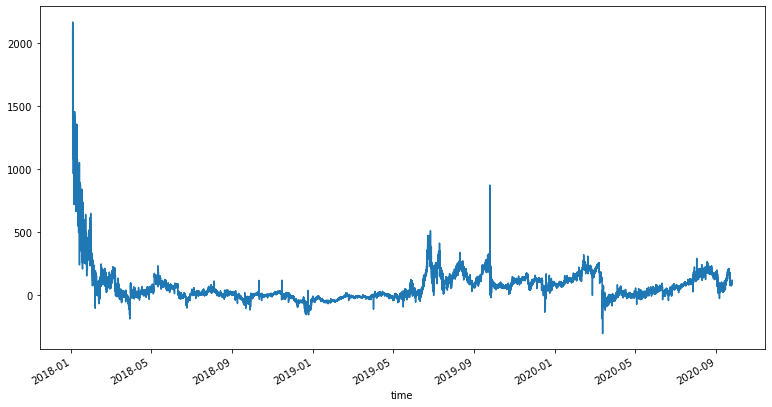

In [385]:
dataset['spread'].plot()

<AxesSubplot:xlabel='spread', ylabel='Density'>

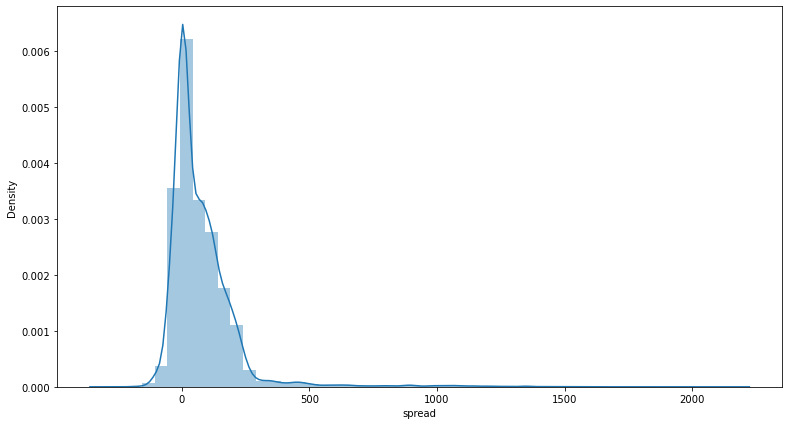

In [386]:
sns.distplot(dataset['spread'])

In [387]:
dataset['spread_ratio'] = (dataset['spread']/dataset['vwap_near'])
## 기초자산 가격대비 스프레드

In [388]:
dataset['spread_ratio'].describe()

count    23804.000000
mean         0.006434
std          0.012199
min         -0.077999
25%         -0.000141
50%          0.004738
75%          0.012796
max          0.135364
Name: spread_ratio, dtype: float64

<AxesSubplot:xlabel='spread_ratio', ylabel='Density'>

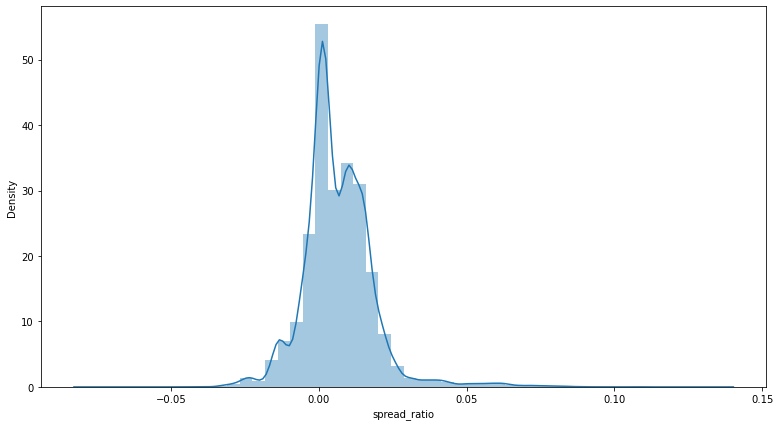

In [389]:
sns.distplot(dataset['spread_ratio'])

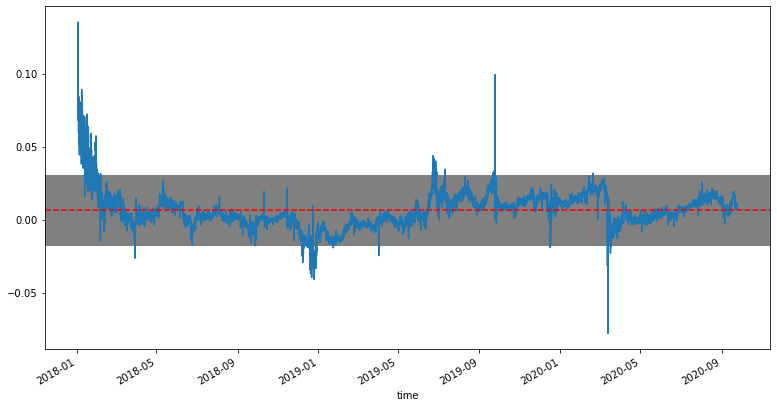

In [390]:
dataset['spread_ratio'].plot()
plt.axhline(dataset['spread_ratio'].mean(), color='r', linestyle='--')
plt.axhspan(dataset['spread_ratio'].mean() - 2*dataset['spread_ratio'].std(),
            dataset['spread_ratio'].mean() + 2*dataset['spread_ratio'].std(), facecolor='gray')
## 당분기물대비 스프레드는 2표준편차내에서 진동하는 것처럼 보임

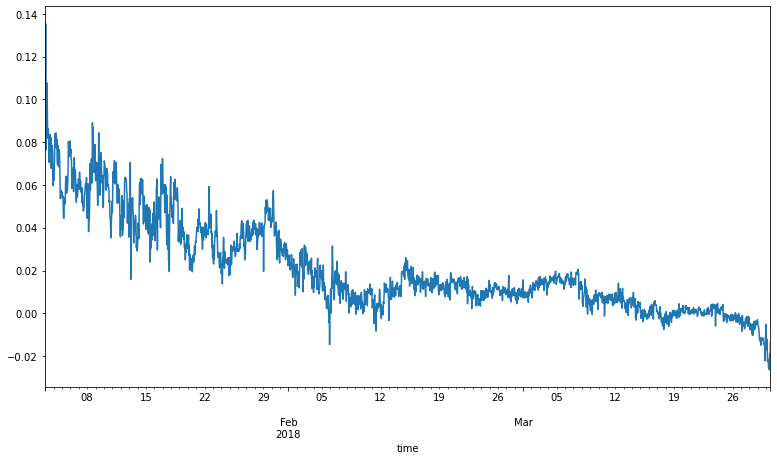

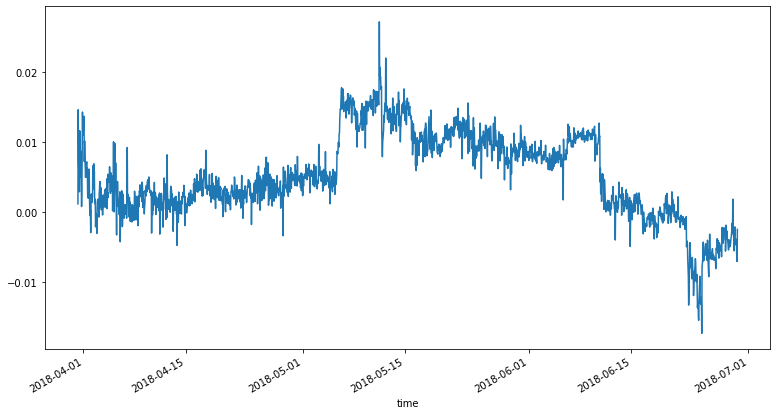

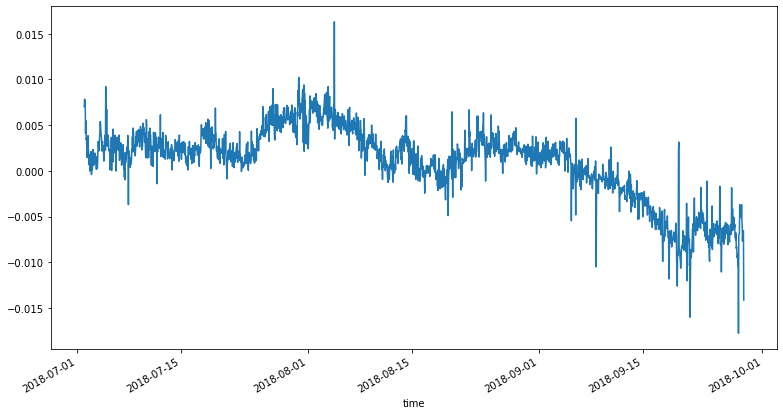

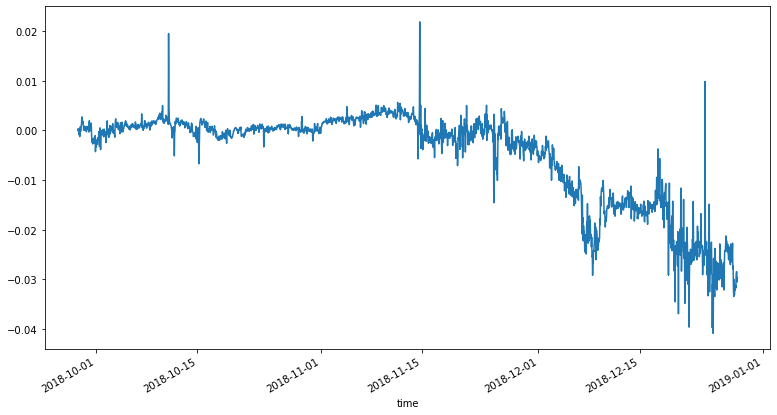

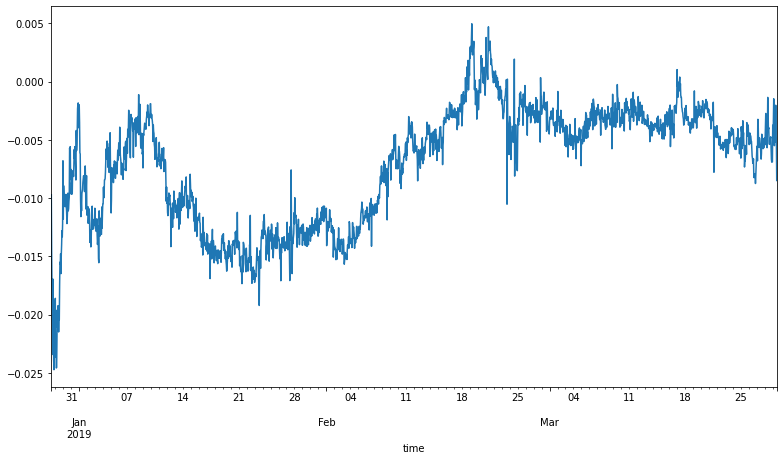

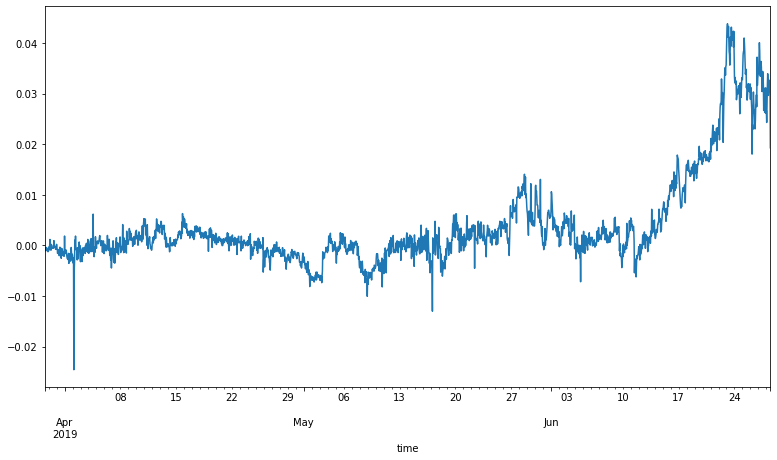

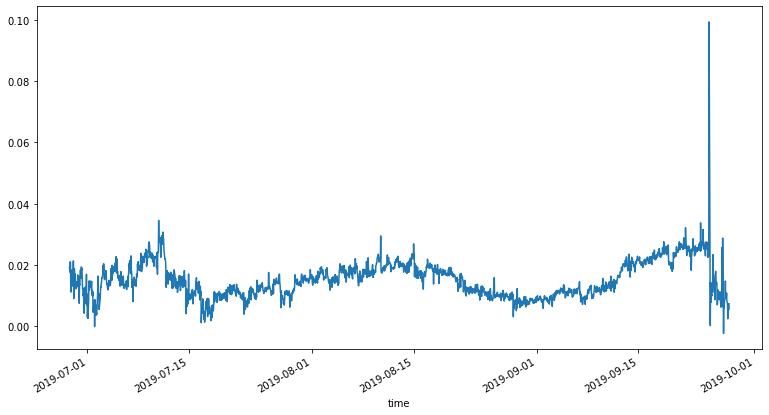

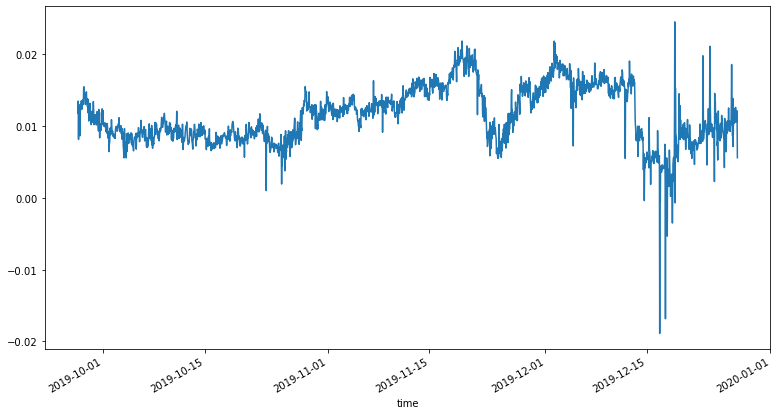

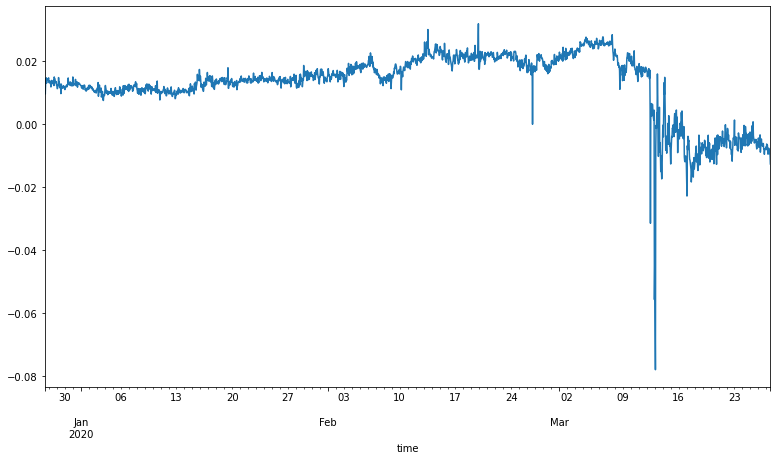

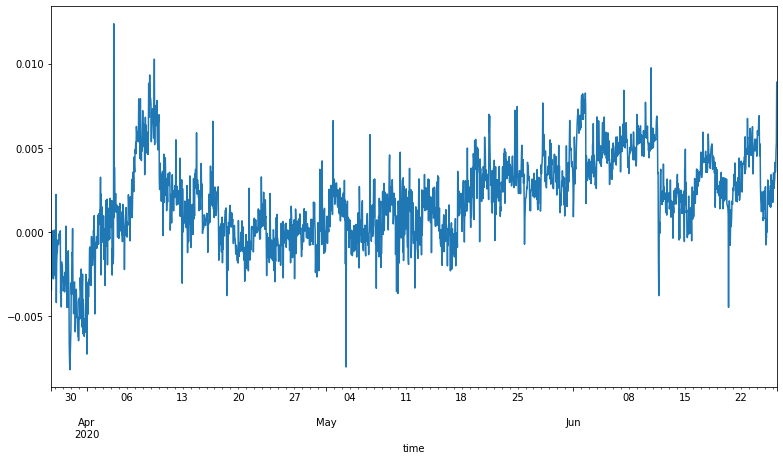

In [391]:
for i in range(1, 11):
    ## 에피소드
    test = dataset[dataset['epi_no'] == i].copy()
    test['spread_ratio'].plot()
    plt.show()

In [392]:
## 에피소드 종료시 스프레드
temp = dataset.drop_duplicates(subset='epi_no', keep='last')
temp

vwap_near   vwap_longer  volume_near  volume_longer  \
time                                                                          
2018-03-30 12:00:00   6975.446400   6882.312500   23552199.0        57045.0   
2018-06-29 12:00:00   5862.352000   5847.611300      53816.0          525.0   
2018-09-28 12:00:00   6647.000000   6553.045074      80605.0      5726840.0   
2018-12-28 11:00:00   3623.283112   3515.797945     424396.0      1048942.0   
2019-03-29 12:00:00   4095.004100   4060.275546      32322.0      3100561.0   
2019-06-28 12:00:00  11920.371900  12150.572720   19452013.0     13643590.0   
2019-09-27 12:00:00   7980.209100   8038.756391   22173759.0      6588761.0   
2019-12-27 11:00:00   7177.156980   7217.161407      68859.0      4950205.0   
2020-03-27 12:00:00   6673.340000   6588.717945   21819201.0      2759250.0   
2020-06-26 12:00:00   9165.902800   9247.460609   35577544.0      2647907.0   
2020-09-24 15:00:00  10400.983192  10503.454168      26872.0       260190.0   

                     duetime      spread  epi_no  spread_ratio  
time                                                            
2018-03-30 12:00:00      0.0  -93.133900       1     -0.013352  
2018-06-29 12:00:00      0.0  -14.740700       2     -0.002514  
2018-09-28 12:00:00      0.0  -93.954926       3     -0.014135  
2018-12-28 11:00:00      0.0 -107.485167       4     -0.029665  
2019-03-29 12:00:00      0.0  -34.728554       5     -0.008481  
2019-06-28 12:00:00      0.0  230.200820       6      0.019312  
2019-09-27 12:00:00      0.0   58.547291       7      0.007337  
2019-12-27 11:00:00      0.0   40.004428       8      0.005574  
2020-03-27 12:00:00      0.0  -84.622055       9     -0.012681  
2020-06-26 12:00:00      0.0   81.557809      10      0.008898  
2020-09-24 15:00:00      0.0  102.470975      11      0.009852

In [393]:
temp[['spread', 'spread_ratio']].describe()
## 이론적 스프레드를 결제시점 스프레드의 통계량으로 정의할 수 있음
## ex) 결제시점 역사점 최대최소 스프레드 내에서는 거래하지 않는 방식

spread  spread_ratio
count   11.000000     11.000000
mean     7.646911     -0.002714
std    105.909429      0.014318
min   -107.485167     -0.029665
25%    -88.877977     -0.013016
50%    -14.740700     -0.002514
75%     70.052550      0.008117
max    230.200820      0.019312

#### 거래량

In [394]:
dataset[['volume_near', 'volume_longer']].describe()
## 거래량의 편차가 매우 큼
## 거래량이 작을 경우 과도한 슬리피지가 발생할 수 있음

volume_near  volume_longer
count  2.380400e+04   2.380400e+04
mean   2.440889e+06   1.502060e+06
std    3.522150e+06   2.938841e+06
min    1.510000e+02   1.000000e+01
25%    5.964532e+05   3.609948e+05
50%    1.365240e+06   7.951910e+05
75%    2.953196e+06   1.692820e+06
max    1.241662e+08   1.921235e+08

<AxesSubplot:xlabel='time'>

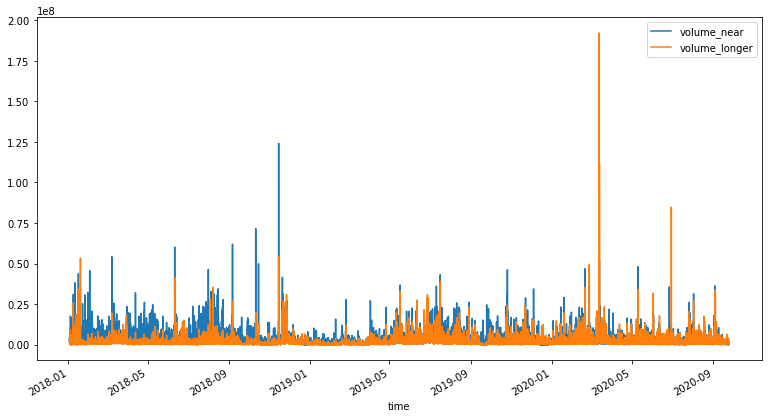

In [395]:
dataset[['volume_near', 'volume_longer']].plot()

In [396]:
dataset['volume_near_log'] = np.log(dataset['volume_near'])
dataset['volume_longer_log'] = np.log(dataset['volume_longer'])

<AxesSubplot:xlabel='volume_near_log', ylabel='Density'>

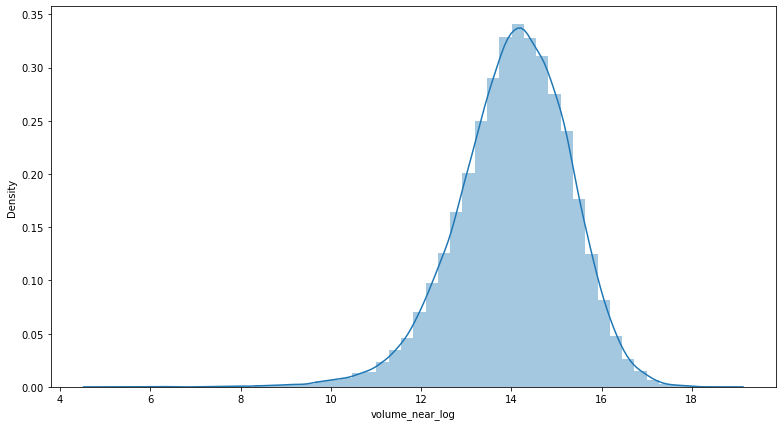

In [397]:
sns.distplot(dataset['volume_near_log'])

<AxesSubplot:xlabel='volume_longer_log', ylabel='Density'>

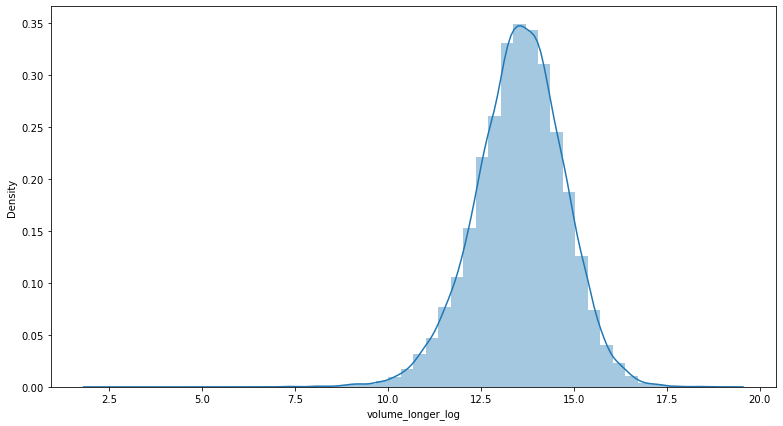

In [398]:
sns.distplot(dataset['volume_longer_log'])

#### 가격

In [399]:
## 에피소드 수익률
dfs = []
for i in range(1, 12):
    ## 에피소드
    temp = dataset[dataset['epi_no'] == i].copy()
    temp['vwap_near_rets'] = temp['vwap_near'].pct_change()
    temp['vwap_longer_rets'] = temp['vwap_longer'].pct_change()

    temp['vwap_near_rets_abs'] = temp['vwap_near_rets'].abs()
    temp['vwap_longer_rets_abs'] = temp['vwap_longer_rets'].abs()
    dfs.append(temp)
    
dataset_v2 = pd.concat(dfs).dropna()

<AxesSubplot:xlabel='vwap_near_rets', ylabel='Density'>

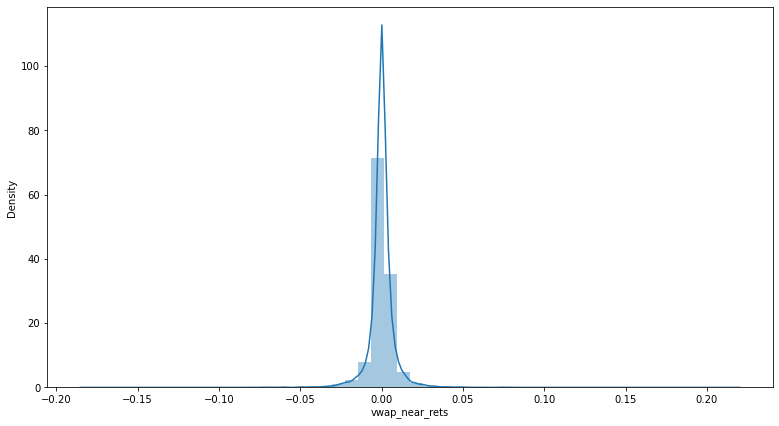

In [400]:
sns.distplot(dataset_v2['vwap_near_rets'])

<AxesSubplot:xlabel='vwap_longer_rets', ylabel='Density'>

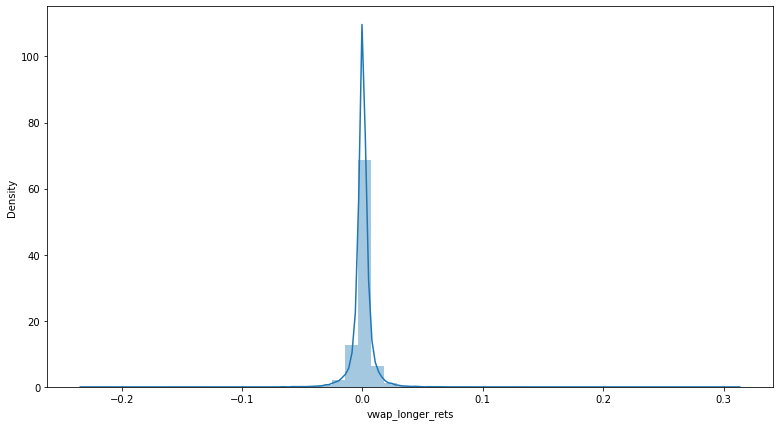

In [401]:
sns.distplot(dataset_v2['vwap_longer_rets'])

In [402]:
## 꼬리가 매우 두꺼운 것이 관찰된다. => 급락급등이 나타날 수 있음(1단위 최대 변동률 20%이상)

### 상관분석

In [403]:
## 상관분석 대상 컬럼
df_corr = dataset_v2[['spread', 'spread_ratio', 'duetime', 'vwap_near', 'vwap_longer', 'volume_near_log', 'volume_longer_log', 'vwap_near_rets',
            'vwap_longer_rets', 'vwap_near_rets_abs', 'vwap_longer_rets_abs']]

In [404]:
features = ['duetime', 'vwap_near', 'vwap_longer', 'volume_near_log', 'volume_longer_log',
            'vwap_near_rets', 'vwap_longer_rets', 'vwap_near_rets_abs', 'vwap_longer_rets_abs']

spread & duetime 상관계수
0.13
corr: 0.13


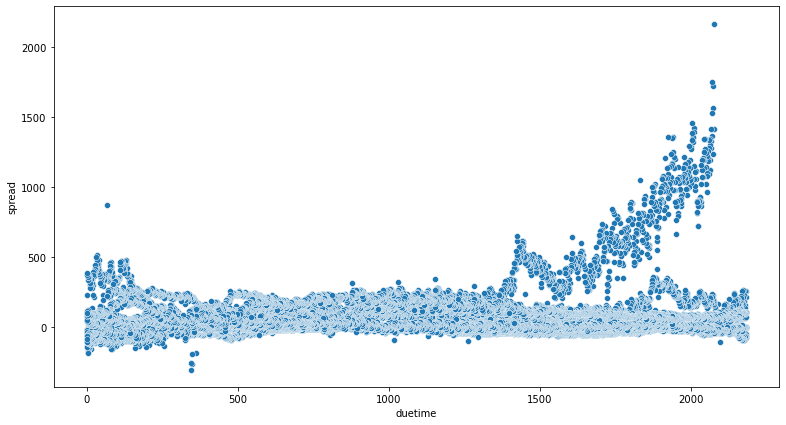

spread & vwap_near 상관계수
0.74
corr: 0.74


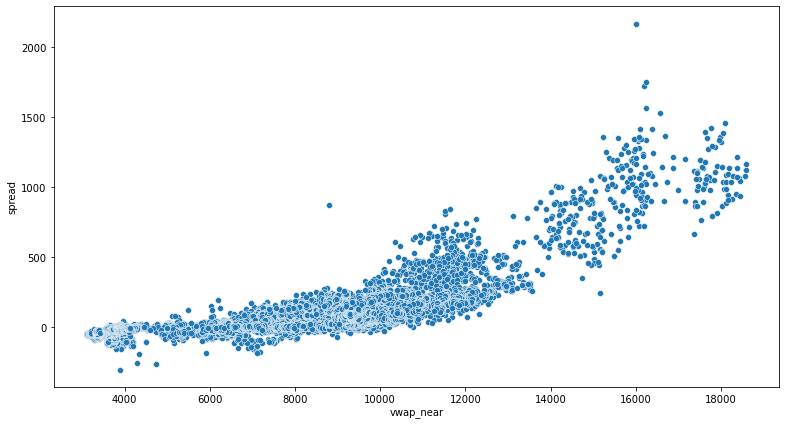

spread & vwap_longer 상관계수
0.76
corr: 0.76


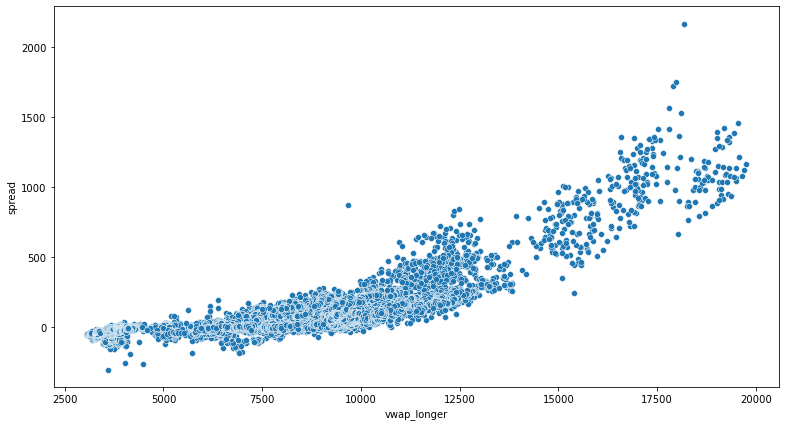

spread & volume_near_log 상관계수
0.19
corr: 0.19


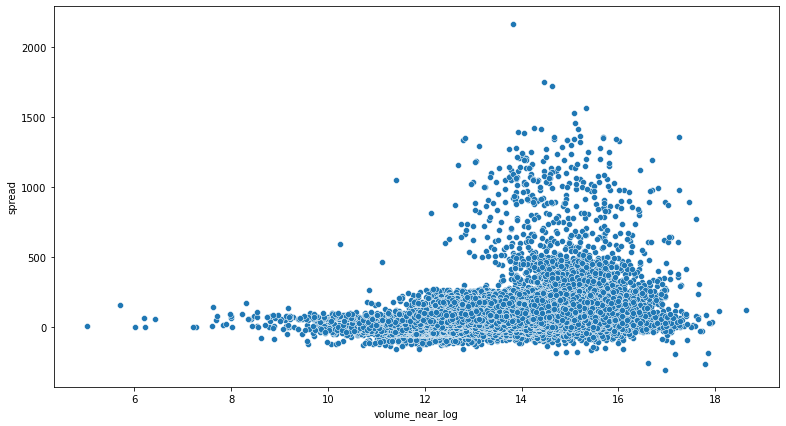

spread & volume_longer_log 상관계수
0.06
corr: 0.06


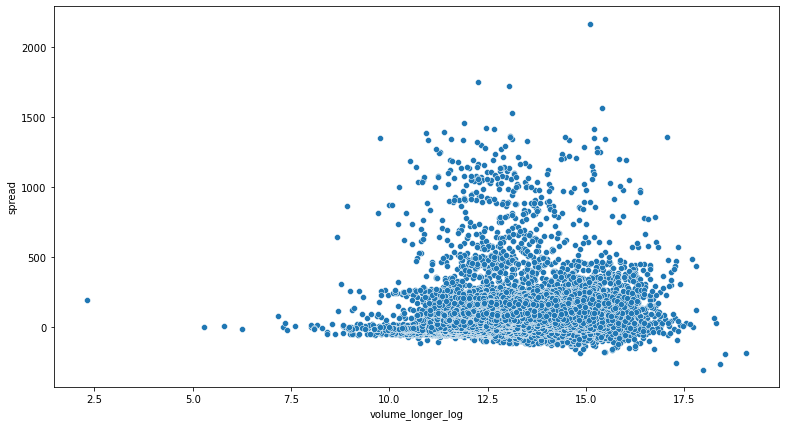

spread & vwap_near_rets 상관계수
-0.02
corr: -0.02


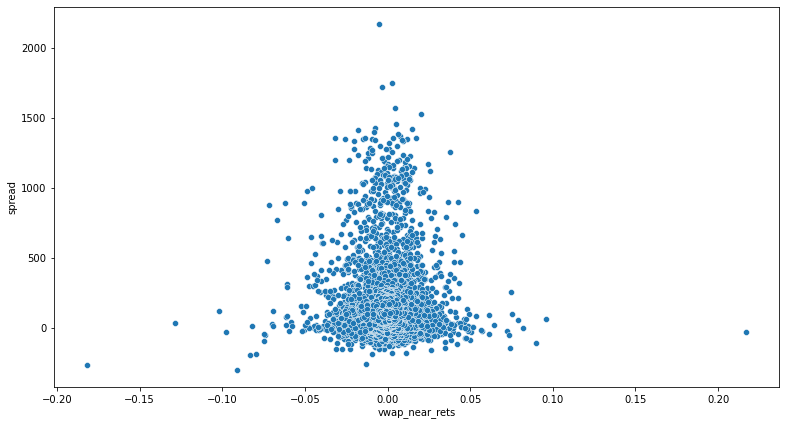

spread & vwap_longer_rets 상관계수
0.01
corr: 0.01


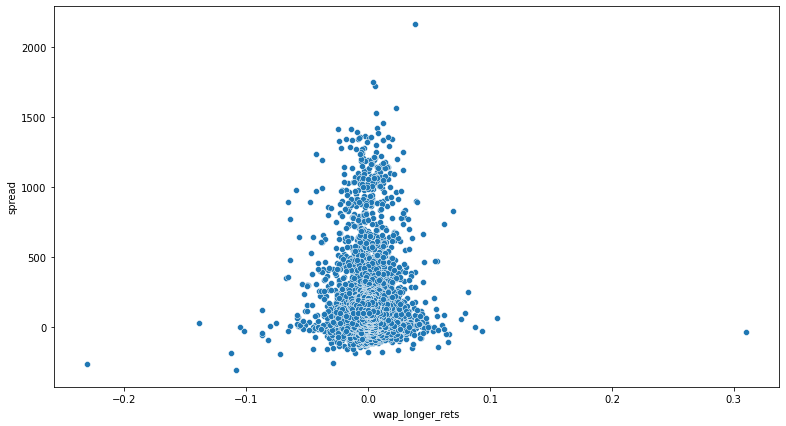

spread & vwap_near_rets_abs 상관계수
0.14
corr: 0.14


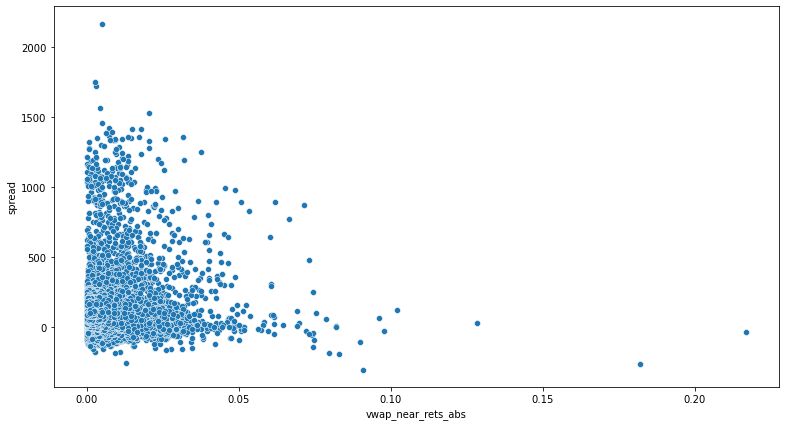

spread & vwap_longer_rets_abs 상관계수
0.14
corr: 0.14


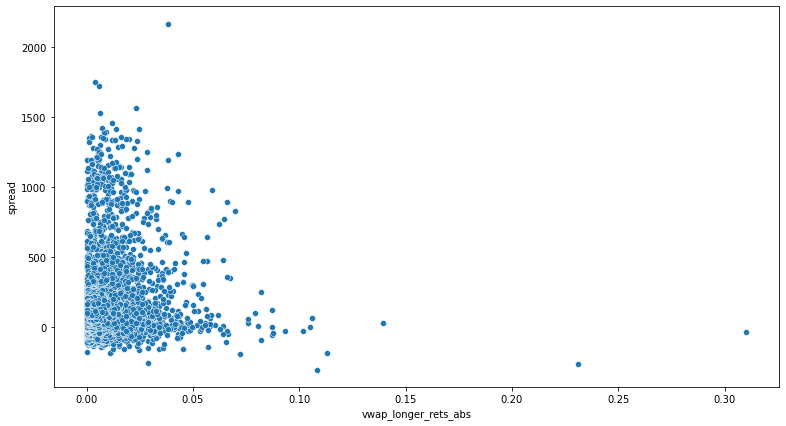

In [405]:
for col in features:
    print(f"spread & {col} 상관계수")
    sns.scatterplot(data=df_corr, x = col, y = 'spread')
    print(df_corr['spread'].corr(df_corr[col]).round(2))
    print(f"corr: {df_corr['spread'].corr(df_corr[col]).round(2)}")
    plt.show()

spread_ratio & duetime
corr: 0.13


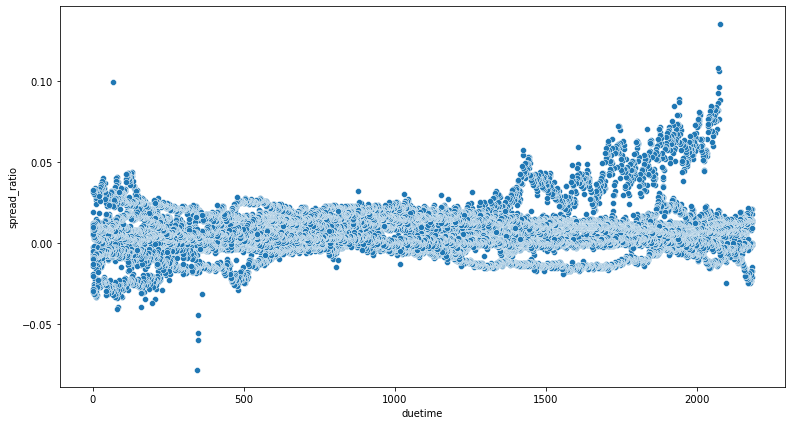

spread_ratio & vwap_near
corr: 0.8


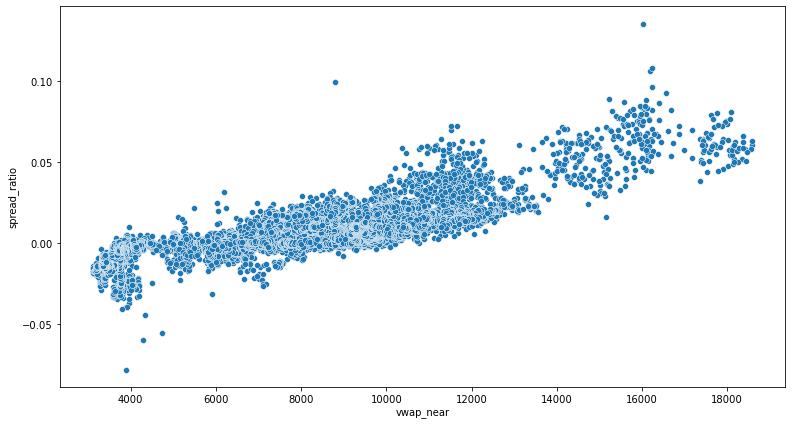

spread_ratio & vwap_longer
corr: 0.82


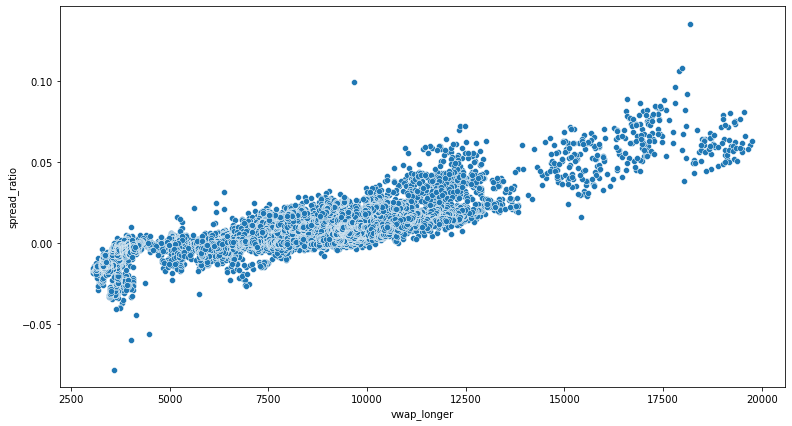

spread_ratio & volume_near_log
corr: 0.25


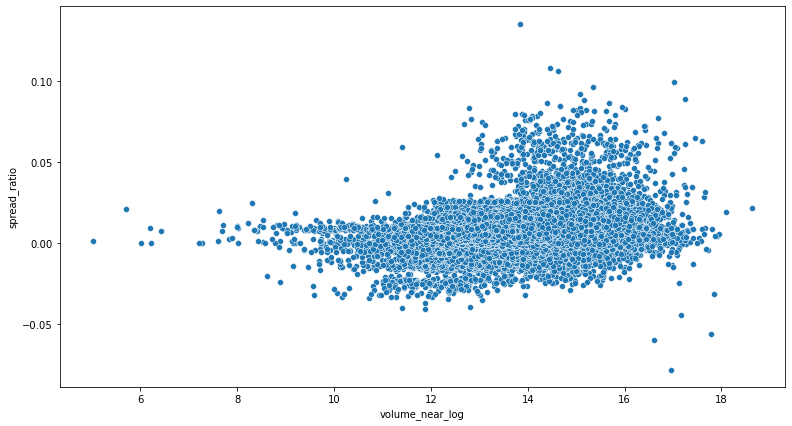

spread_ratio & volume_longer_log
corr: 0.11


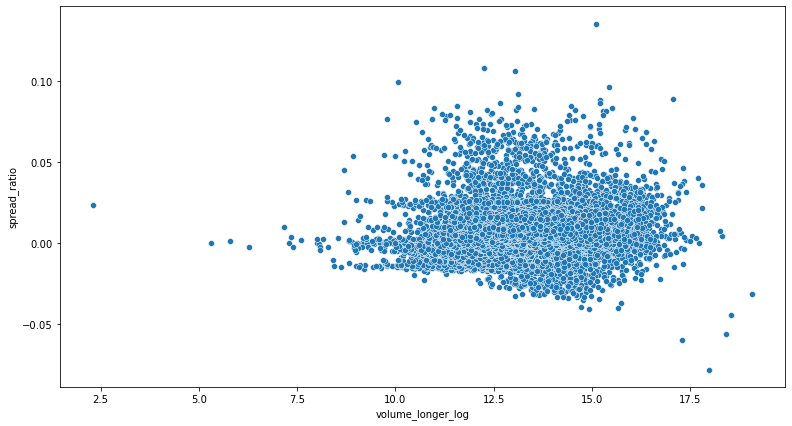

spread_ratio & vwap_near_rets
corr: -0.02


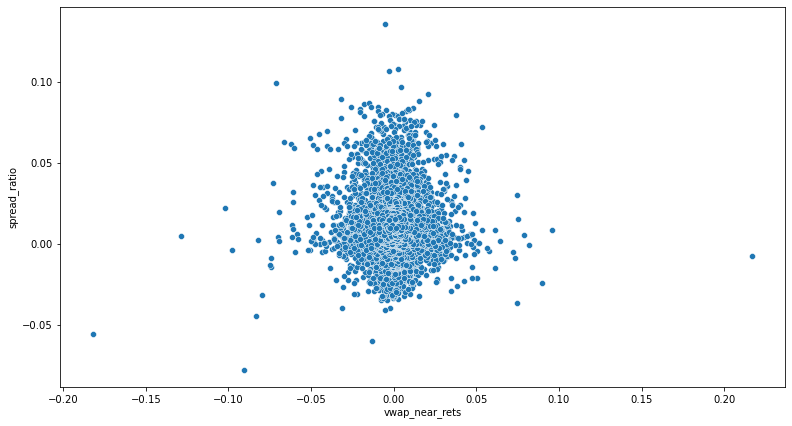

spread_ratio & vwap_longer_rets
corr: 0.01


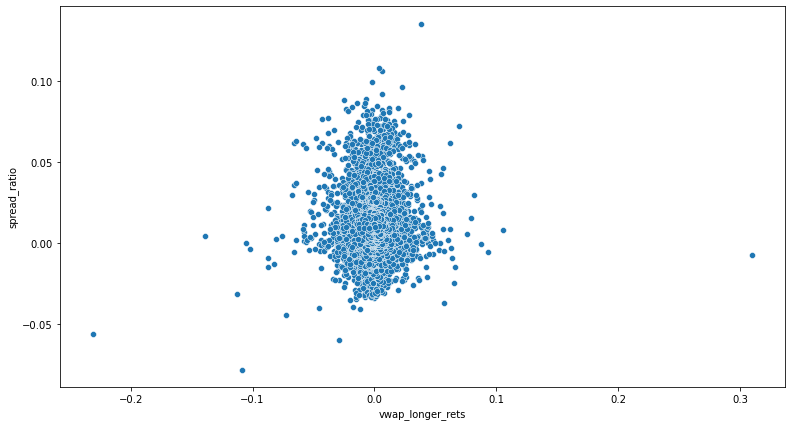

spread_ratio & vwap_near_rets_abs
corr: 0.11


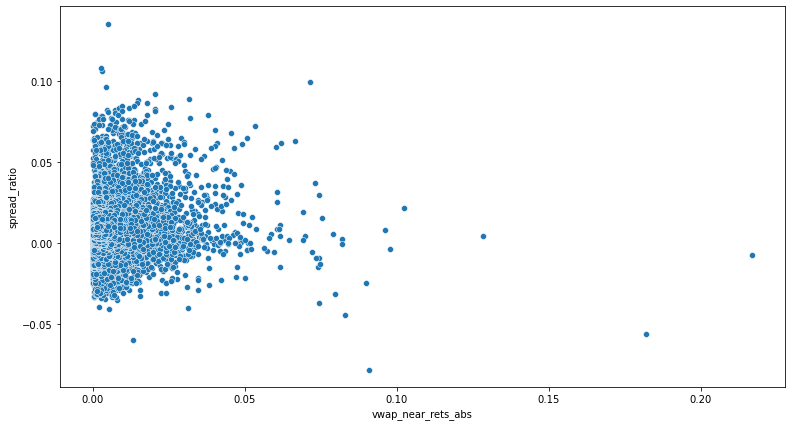

spread_ratio & vwap_longer_rets_abs
corr: 0.1


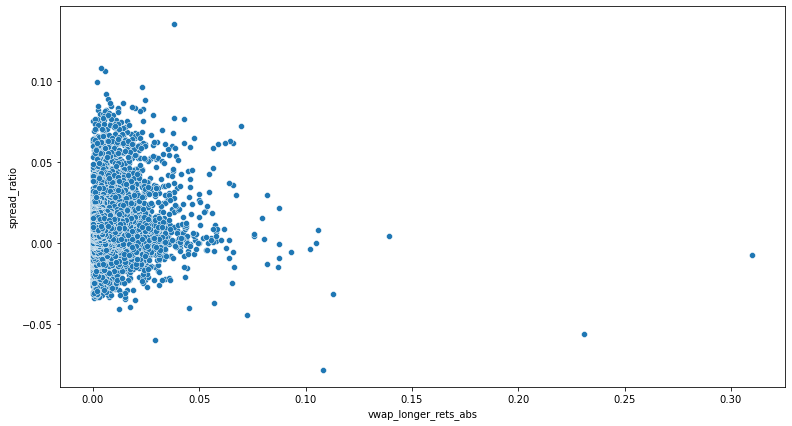

In [406]:
for col in features:
    print(f"spread_ratio & {col}")
    sns.scatterplot(data=df_corr, x = col, y = 'spread_ratio')
    print(f"corr: {df_corr['spread_ratio'].corr(df_corr[col]).round(2)}")
    plt.show()

* 기초자산의 가격수준 자체가 Spread_ratio와 높은 상관관계가 나오는 현상을 어떻게 이해할 수 있을까?  
  - 높은 기초자산 가격은 고평가로 단기적인 가격하락을 예상하기 때문에 당분기 선물에 대한 매도가 발생한다.
  - 반면 차분기 선물에 대한 매도는 상대적으로 적기 때문에 스프레드가 커진다.
  - or
  - 기초자산 매수세로 기초자산의 가격이 높아졌고, 이에 대한 헷지 포지션으로 당분기 선물에 대한 매도가 발생한다.
  - or
  - 가성적관계 => 기초자산의 가격이 분석기간 동안 하락세였고, 스프레드는 시장이 성숙하면서 차츰 줄어들었을 뿐 두 변수간의 관계는 없다.
  - or
  - 단순히 변수생성 자체에 활용되었기 때문

In [407]:
df_corr.corr()[['spread', 'spread_ratio']]

spread  spread_ratio
spread                1.000000      0.931273
spread_ratio          0.931273      1.000000
duetime               0.131505      0.128055
vwap_near             0.739080      0.798001
vwap_longer           0.762887      0.815760
volume_near_log       0.194742      0.248021
volume_longer_log     0.063602      0.106967
vwap_near_rets       -0.016280     -0.016131
vwap_longer_rets      0.005863      0.013170
vwap_near_rets_abs    0.139804      0.112089
vwap_longer_rets_abs  0.137182      0.103404

* log거래량, 수익률절대값 과도 약한 상관관계가 관찰된다.
* 다만, 이상값에 대한 별도의 처리가 없었으므로, 해석에 제한사항이 있다.

#### 이상값 처리

In [408]:
## 극단값 보정 # 윈저라이징 #3std
def clean_outlier(srs, n = 3):
    srs = srs.copy()
    ut = srs.mean() + n*srs.std()
    lt = srs.mean() - n*srs.std()
    srs[(srs > ut)] = ut
    srs[(srs < lt)] = lt
    return srs

In [420]:
dataset_v2

vwap_near   vwap_longer  volume_near  volume_longer  \
time                                                                          
2018-01-03 00:00:00  16095.653652  17512.403599    3880638.0      3991030.0   
2018-01-03 01:00:00  16015.590702  18183.519680    1017262.0      3639333.0   
2018-01-03 02:00:00  16170.207639  17404.895810    2479906.0       322148.0   
2018-01-03 03:00:00  16240.848903  17806.199313    4587485.0      4973513.0   
2018-01-03 04:00:00  16191.252654  17911.064731    2269056.0       460823.0   
...                           ...           ...          ...            ...   
2020-09-24 11:00:00  10398.394456  10506.157375    1089983.0      2222261.0   
2020-09-24 12:00:00  10385.575787  10506.570149     509872.0       785774.0   
2020-09-24 13:00:00  10363.081012  10460.789864     490564.0       722780.0   
2020-09-24 14:00:00  10388.216869  10500.852793     468308.0       873974.0   
2020-09-24 15:00:00  10400.983192  10503.454168      26872.0       260190.0   

                     duetime       spread  epi_no  spread_ratio  \
time                                                              
2018-01-03 00:00:00   2076.0  1416.749946       1      0.088021   
2018-01-03 01:00:00   2075.0  2167.928978       1      0.135364   
2018-01-03 02:00:00   2074.0  1234.688170       1      0.076356   
2018-01-03 03:00:00   2073.0  1565.350410       1      0.096384   
2018-01-03 04:00:00   2072.0  1719.812077       1      0.106219   
...                      ...          ...     ...           ...   
2020-09-24 11:00:00      4.0   107.762919      11      0.010363   
2020-09-24 12:00:00      3.0   120.994362      11      0.011650   
2020-09-24 13:00:00      2.0    97.708853      11      0.009429   
2020-09-24 14:00:00      1.0   112.635924      11      0.010843   
2020-09-24 15:00:00      0.0   102.470975      11      0.009852   

                     volume_near_log  volume_longer_log  vwap_near_rets  \
time                                                                      
2018-01-03 00:00:00        15.171510          15.199560        0.015016   
2018-01-03 01:00:00        13.832625          15.107311       -0.004974   
2018-01-03 02:00:00        14.723731          12.682766        0.009654   
2018-01-03 03:00:00        15.338843          15.419637        0.004369   
2018-01-03 04:00:00        14.634874          13.040769       -0.003054   
...                              ...                ...             ...   
2020-09-24 11:00:00        13.901673          14.614036        0.005109   
2020-09-24 12:00:00        13.141915          13.574424       -0.001233   
2020-09-24 13:00:00        13.103311          13.490860       -0.002166   
2020-09-24 14:00:00        13.056881          13.680806        0.002426   
2020-09-24 15:00:00        10.198840          12.469167        0.001229   

                     vwap_longer_rets  vwap_near_rets_abs  \
time                                                        
2018-01-03 00:00:00         -0.024663            0.015016   
2018-01-03 01:00:00          0.038322            0.004974   
2018-01-03 02:00:00         -0.042820            0.009654   
2018-01-03 03:00:00          0.023057            0.004369   
2018-01-03 04:00:00          0.005889            0.003054   
...                               ...                 ...   
2020-09-24 11:00:00          0.007199            0.005109   
2020-09-24 12:00:00          0.000039            0.001233   
2020-09-24 13:00:00         -0.004357            0.002166   
2020-09-24 14:00:00          0.003830            0.002426   
2020-09-24 15:00:00          0.000248            0.001229   

                     vwap_longer_rets_abs  
time                                       
2018-01-03 00:00:00              0.024663  
2018-01-03 01:00:00              0.038322  
2018-01-03 02:00:00              0.042820  
2018-01-03 03:00:00              0.023057  
2018-01-03 04:00:00              0.005889  
...                                   ...  
20

In [410]:
## 3표준편차 이상의 극단값 전처리
dataset_v3 = dataset_v2.copy()
variables = ['spread', 'spread_ratio', 'volume_near_log', 'volume_longer_log', 'vwap_near_rets', 'vwap_longer_rets', 'vwap_near_rets_abs', 'vwap_longer_rets_abs']

for var in variables:
    dataset_v3[var] = clean_outlier(dataset_v3[var])

In [411]:
## 상관분석 대상 컬럼
df_corr_v2 = dataset_v3[['spread', 'spread_ratio', 'duetime', 'vwap_near', 'vwap_longer', 'volume_near_log', 'volume_longer_log', 'vwap_near_rets',
            'vwap_longer_rets', 'vwap_near_rets_abs', 'vwap_longer_rets_abs']]

spread & duetime 상관계수
0.1
corr: 0.1


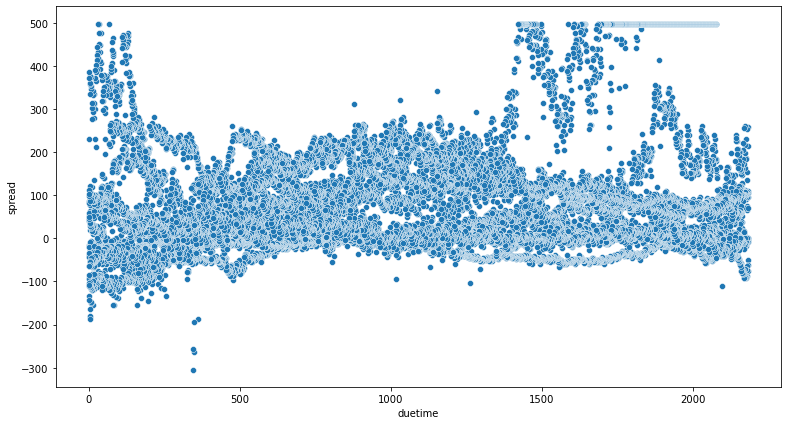

spread & vwap_near 상관계수
0.8
corr: 0.8


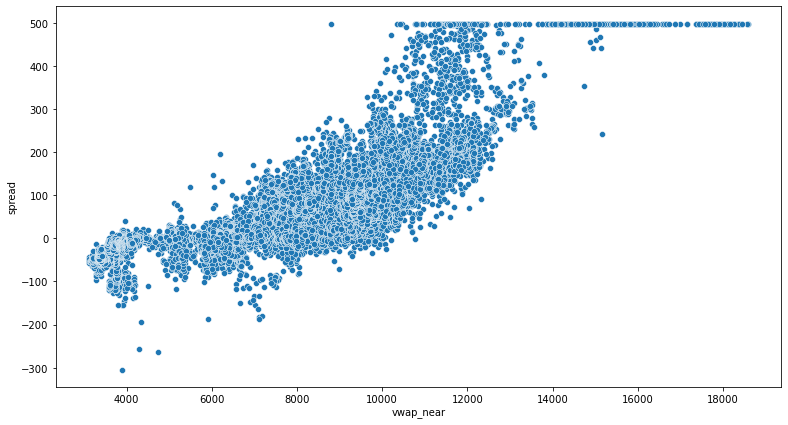

spread & vwap_longer 상관계수
0.82
corr: 0.82


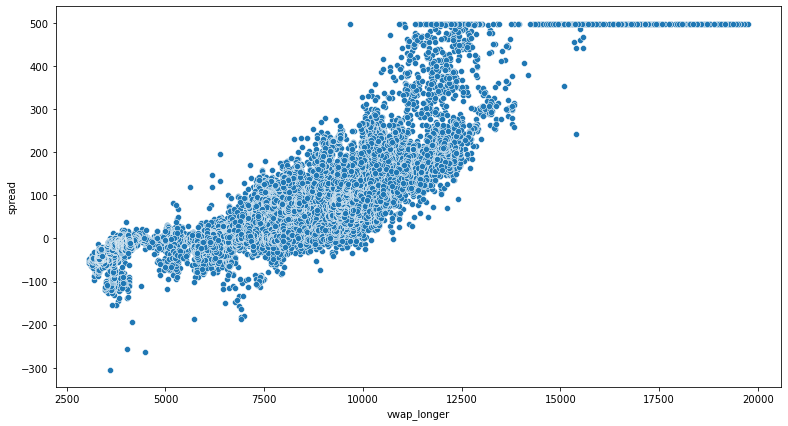

spread & volume_near_log 상관계수
0.23
corr: 0.23


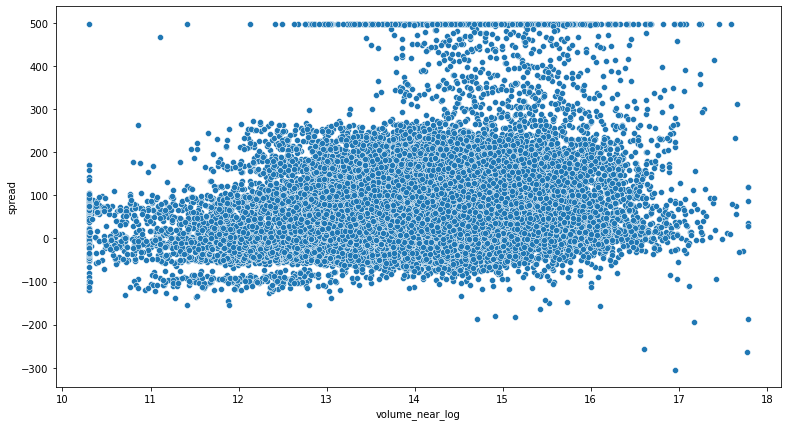

spread & volume_longer_log 상관계수
0.11
corr: 0.11


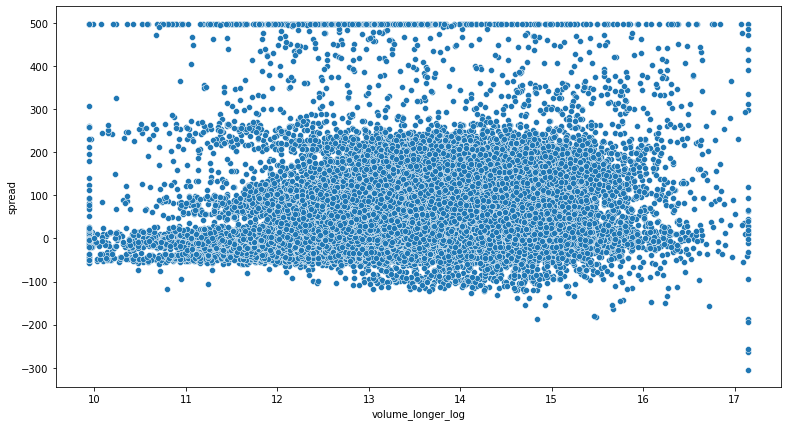

spread & vwap_near_rets 상관계수
-0.01
corr: -0.01


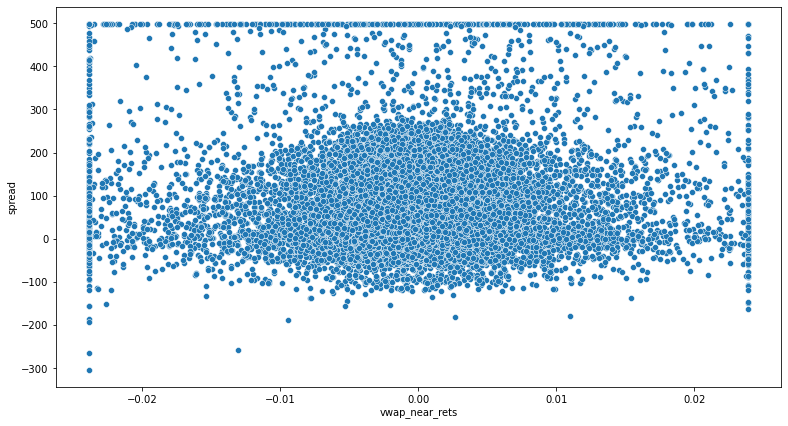

spread & vwap_longer_rets 상관계수
0.01
corr: 0.01


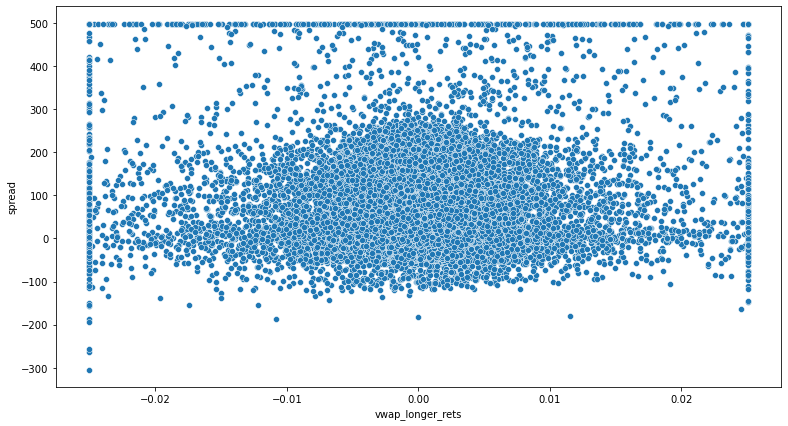

spread & vwap_near_rets_abs 상관계수
0.16
corr: 0.16


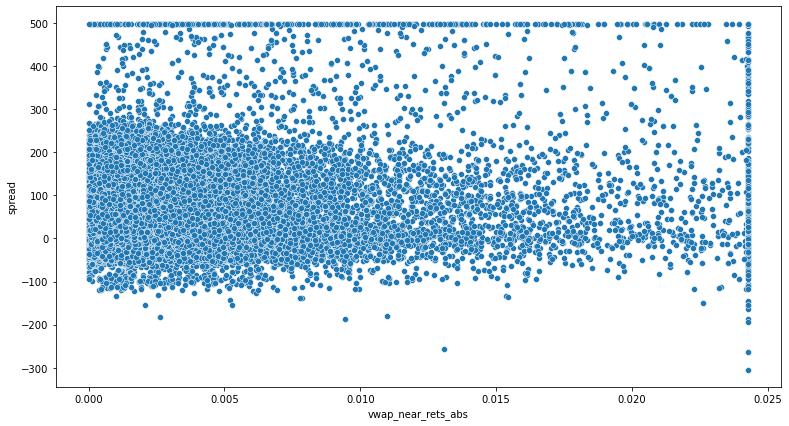

spread & vwap_longer_rets_abs 상관계수
0.16
corr: 0.16


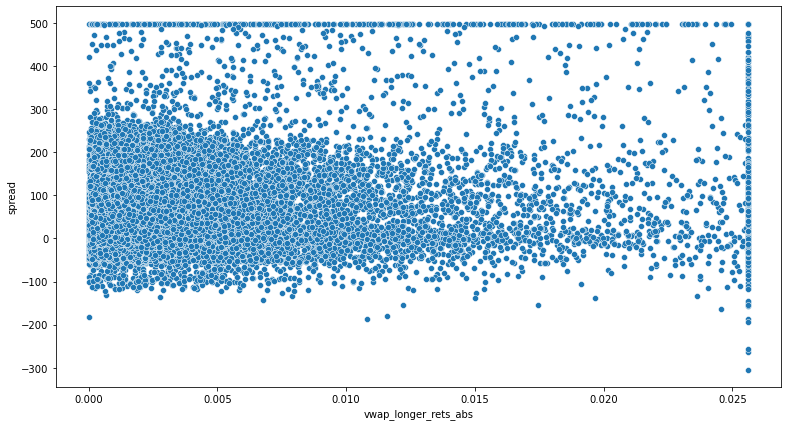

In [412]:
for col in features:
    print(f"spread & {col} 상관계수")
    sns.scatterplot(data=df_corr_v2, x = col, y = 'spread')
    print(df_corr_v2['spread'].corr(df_corr_v2[col]).round(2))
    print(f"corr: {df_corr_v2['spread'].corr(df_corr_v2[col]).round(2)}")
    plt.show()

spread_ratio & duetime
corr: 0.11


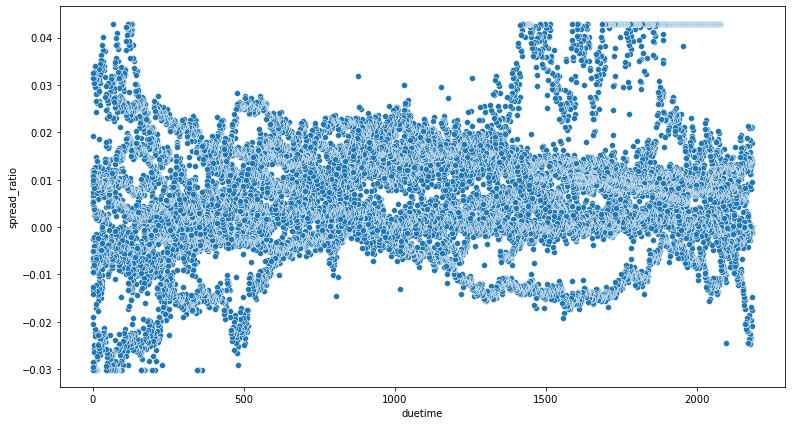

spread_ratio & vwap_near
corr: 0.81


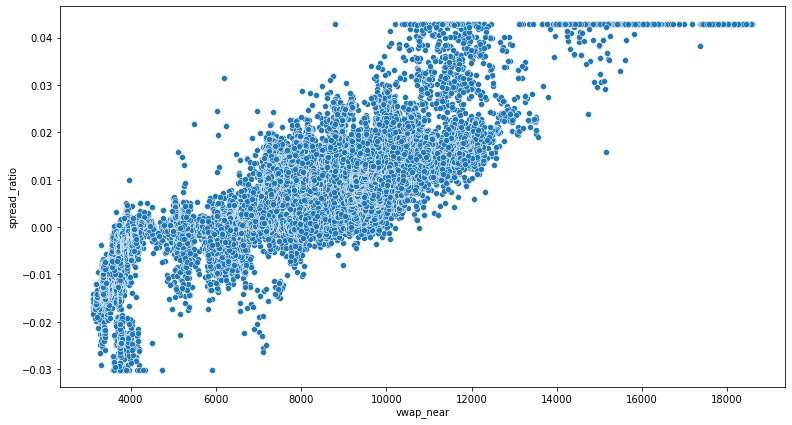

spread_ratio & vwap_longer
corr: 0.82


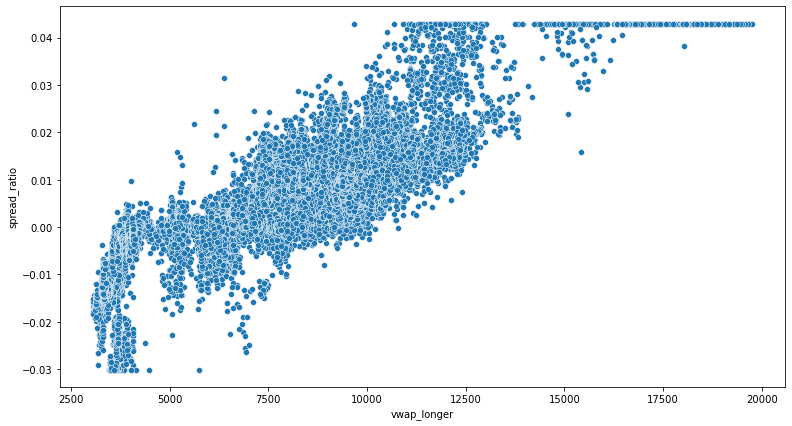

spread_ratio & volume_near_log
corr: 0.26


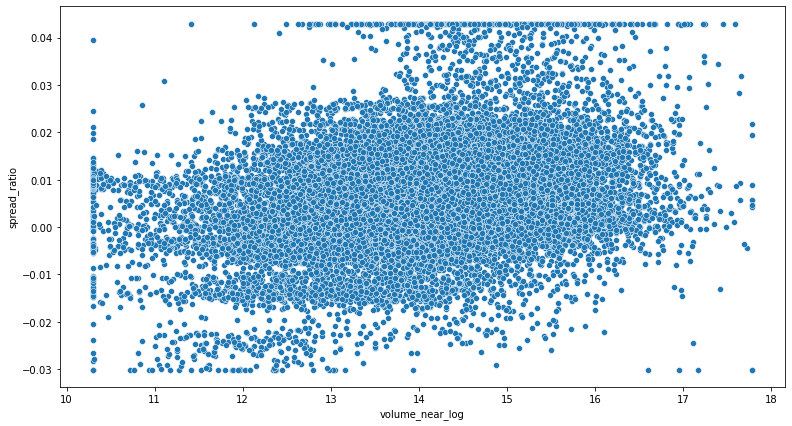

spread_ratio & volume_longer_log
corr: 0.13


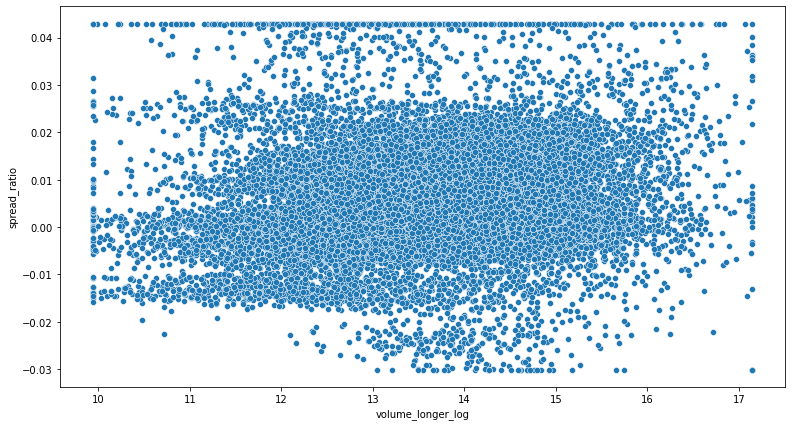

spread_ratio & vwap_near_rets
corr: -0.01


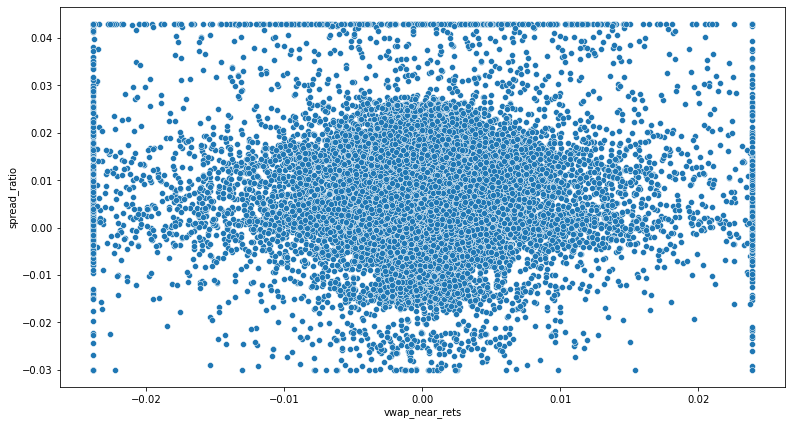

spread_ratio & vwap_longer_rets
corr: 0.01


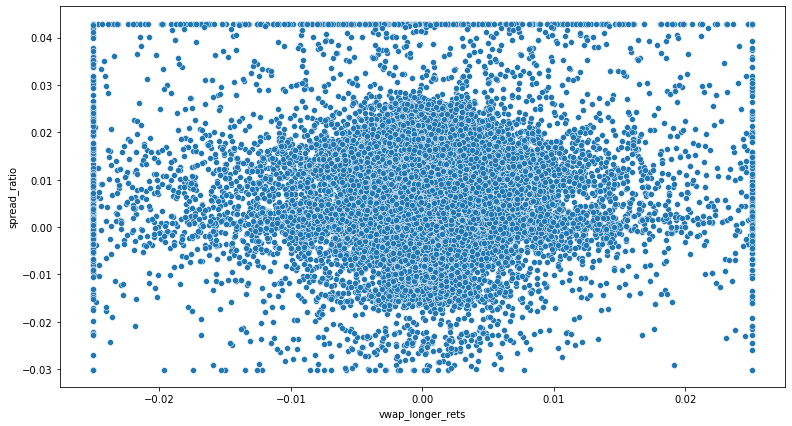

spread_ratio & vwap_near_rets_abs
corr: 0.13


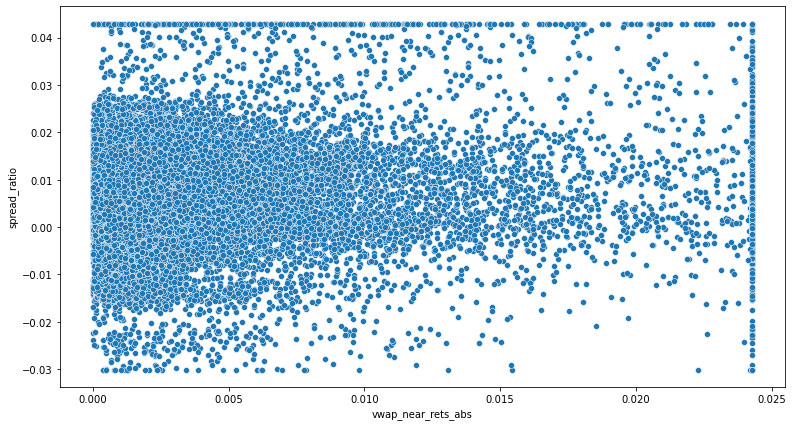

spread_ratio & vwap_longer_rets_abs
corr: 0.12


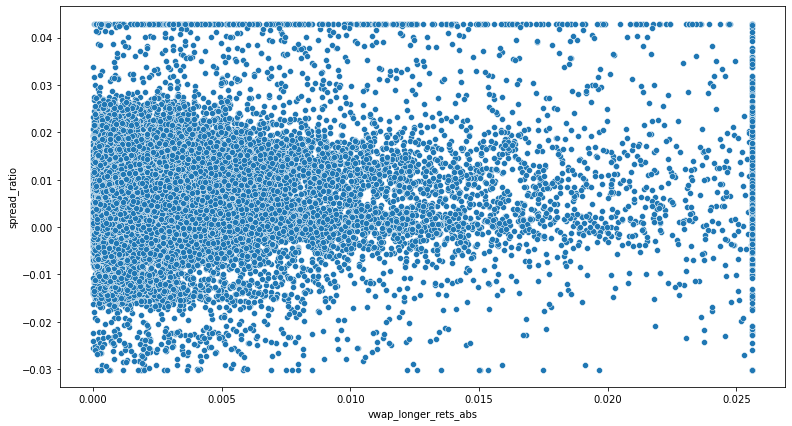

In [413]:
for col in features:
    print(f"spread_ratio & {col}")
    sns.scatterplot(data=df_corr_v2, x = col, y = 'spread_ratio')
    print(f"corr: {df_corr_v2['spread_ratio'].corr(df_corr_v2[col]).round(2)}")
    plt.show()

In [414]:
df_corr.corr()[['spread', 'spread_ratio']]

spread  spread_ratio
spread                1.000000      0.931273
spread_ratio          0.931273      1.000000
duetime               0.131505      0.128055
vwap_near             0.739080      0.798001
vwap_longer           0.762887      0.815760
volume_near_log       0.194742      0.248021
volume_longer_log     0.063602      0.106967
vwap_near_rets       -0.016280     -0.016131
vwap_longer_rets      0.005863      0.013170
vwap_near_rets_abs    0.139804      0.112089
vwap_longer_rets_abs  0.137182      0.103404

In [415]:
df_corr_v2.corr()[['spread', 'spread_ratio']]

spread  spread_ratio
spread                1.000000      0.957218
spread_ratio          0.957218      1.000000
duetime               0.095563      0.109585
vwap_near             0.801715      0.809440
vwap_longer           0.819096      0.823054
volume_near_log       0.233941      0.264218
volume_longer_log     0.107353      0.126974
vwap_near_rets       -0.010713     -0.013028
vwap_longer_rets      0.008231      0.009177
vwap_near_rets_abs    0.158585      0.129435
vwap_longer_rets_abs  0.155526      0.124072

* 3std로 극단값을 보정한 경우에도 duetime(결제기한), vwap(가격수준), volume_near_log(log거래량), vwap_near_rets_abs(수익률절대값) 등의 변수에서 0.1 이상의 상관계수가 관찰된다.

### 정상성 검정

In [416]:
## 시계열 정상성검정
## adf
def adf_test(timeseries):
    ## print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4], index=[ "Test Statistic", "p-value", "#Lags Used", "Number of Observations Used", ],
    )
    for key, value in dftest[4].items(): dfoutput["Critical Value (%s)" % key] = value
    return (dfoutput)
## kpss
def kpss_test(timeseries):
    ## print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    return (kpss_output)

In [417]:
adf_vars = ['spread', 'spread_ratio', 'vwap_near', 'vwap_longer',
            'volume_near_log', 'volume_longer_log', 'vwap_near_rets',
            'vwap_longer_rets', 'vwap_near_rets_abs', 'vwap_longer_rets_abs']

In [418]:
adf_ls = []
for col in adf_vars:
    adf_temp = adf_test(dataset_v3[col])['p-value']
    kpss_temp = kpss_test(dataset_v3[col])['p-value']
    adf_ls.append((adf_temp, kpss_temp))
adf_res = pd.DataFrame(adf_ls, index=adf_vars, columns=['ADF', 'KPSS']).round(4)

In [419]:
adf_res

ADF    KPSS
spread                0.0000  0.0100
spread_ratio          0.0004  0.0100
vwap_near             0.0091  0.0100
vwap_longer           0.0063  0.0100
volume_near_log       0.0000  0.0100
volume_longer_log     0.0000  0.0100
vwap_near_rets        0.0000  0.0895
vwap_longer_rets      0.0000  0.0551
vwap_near_rets_abs    0.0000  0.0100
vwap_longer_rets_abs  0.0000  0.0100

* 정상성 검정 결과 모든 시계열이 유의수준 0.05에서 ADF 귀무가설(단위근이 있다.)을 기각함
* 하지만, 수익률을 제외한 모든 시계열이 KPSS 귀무가설(정상성이 있다.) 역시 기각함
* ADF와 KPSS 결과가 서로 상충된 결과로 나타난다.

* 차분을 통해 시계열을 정상화할 수 있지만, 차분시 시계열의 수준에 대한 정보가 훼손되므로 공적분 검정을 선행한다.

### 공적분 검정

In [421]:
coint_vars = ['vwap_near', 'vwap_longer',
            'volume_near_log', 'volume_longer_log', 'vwap_near_rets',
            'vwap_longer_rets', 'vwap_near_rets_abs', 'vwap_longer_rets_abs']

In [422]:
coint_ls = []
for col in coint_vars:
    ## print(col)
    score, pvalue, _ = coint(dataset_v3[col], dataset_v3['spread'])
    score, pvalue_, _ = coint(dataset_v3[col], dataset_v3['spread_ratio'])
    coint_ls.append((pvalue, pvalue_))

In [423]:
coint_res = pd.DataFrame(coint_ls, index=coint_vars, columns=['spread', 'spread_ratio']).round(4)

In [424]:
coint_res

spread  spread_ratio
vwap_near             0.0035        0.0005
vwap_longer           0.0029        0.0003
volume_near_log       0.0000        0.0000
volume_longer_log     0.0000        0.0000
vwap_near_rets        0.0000        0.0000
vwap_longer_rets      0.0000        0.0000
vwap_near_rets_abs    0.0000        0.0000
vwap_longer_rets_abs  0.0000        0.0000

* 공적분 검정 결과 모든 시계열이 spread 와 spread_ratio에 대해 유의수준 0.05에서 귀무가설(공적분 개수가 0이다.)를 기각하므로 공적분 관계가 있다고 볼 수 있다.

## 시계열 차분

## Save

In [425]:
dataset_v3.to_csv('data/data_eda.csv')